# The Doubly Robust Estimator

**Chapter 12, Section 1**

This notebook introduces the doubly robust (DR) estimator that combines propensity score weighting with outcome regression.

## Table of Contents
1. [Intuition](#intuition) - Why combine two models?
2. [Formal Treatment](#formal) - The DR formula
3. [Numeric Demonstration](#numeric) - Mindset data application
4. [Implementation](#implementation) - Step-by-step DR
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from sklearn.linear_model import LogisticRegression, LinearRegression

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The Problem with Single-Model Approaches

**IPTW** (propensity score only):
- Requires correct PS model
- Can be unstable with extreme weights
- Doesn't use outcome information

**Outcome Regression** (outcome model only):
- Requires correct outcome model
- Extrapolates in regions without data
- Doesn't account for treatment selection

### The Doubly Robust Solution

**Key idea**: Combine both models for "insurance" - if either model is correct, you get consistent estimates.

$$\text{DR} = \text{Outcome Model} + \text{IPTW Correction}$$

---

In [2]:
# Load mindset data
mindset = load_facure_data("learning_mindset.csv")

covariates = [
    'success_expect', 'ethnicity', 'gender', 'frst_in_family',
    'school_mindset', 'school_achievement', 'school_ethnic_minority',
    'school_poverty', 'school_size'
]

X = mindset[covariates].values
T = mindset['intervention'].values
Y = mindset['achievement_score'].values

print(f"Data: {len(mindset)} students")
print(f"Treatment rate: {T.mean():.1%}")

Data: 10391 students
Treatment rate: 32.6%


---

## Formal Treatment

### The Doubly Robust Estimator

**Definition**: The DR estimator for ATE is:

$$\hat{\tau}_{DR} = \frac{1}{n}\sum_{i=1}^{n} \left[ \hat{\mu}_1(X_i) - \hat{\mu}_0(X_i) + \frac{T_i(Y_i - \hat{\mu}_1(X_i))}{\hat{e}(X_i)} - \frac{(1-T_i)(Y_i - \hat{\mu}_0(X_i))}{1-\hat{e}(X_i)} \right]$$

Where:
- $\hat{\mu}_1(X)$: Predicted outcome under treatment
- $\hat{\mu}_0(X)$: Predicted outcome under control
- $\hat{e}(X)$: Estimated propensity score

### Decomposition

The DR estimator has two parts:

1. **Outcome model term**: $\hat{\mu}_1(X_i) - \hat{\mu}_0(X_i)$
2. **IPTW correction term**: Adjusts for errors in outcome model

### For ATT

$$\hat{\tau}_{ATT}^{DR} = \frac{1}{n_1}\sum_{i:T_i=1} \left[ Y_i - \hat{\mu}_0(X_i) - \frac{(1-T_i)\hat{e}(X_i)(Y_i - \hat{\mu}_0(X_i))}{(1-\hat{e}(X_i))P(T=1)} \right]$$

---

In [3]:
def doubly_robust_ate(X, T, Y):
    """
    Doubly Robust estimator for ATE.
    
    Parameters:
    -----------
    X : covariate matrix
    T : treatment indicator
    Y : outcome
    
    Returns:
    --------
    dict with ATE estimate and components
    """
    n = len(Y)
    
    # Step 1: Estimate propensity scores
    ps_model = LogisticRegression(C=1e6, max_iter=1000, solver='lbfgs')
    ps_model.fit(X, T)
    ps = ps_model.predict_proba(X)[:, 1]
    
    # Step 2: Estimate outcome models
    # Model for treated: E[Y|X, T=1]
    mu1_model = LinearRegression()
    mu1_model.fit(X[T==1], Y[T==1])
    mu1 = mu1_model.predict(X)
    
    # Model for control: E[Y|X, T=0]
    mu0_model = LinearRegression()
    mu0_model.fit(X[T==0], Y[T==0])
    mu0 = mu0_model.predict(X)
    
    # Step 3: Compute DR estimator
    # Outcome model component
    outcome_component = mu1 - mu0
    
    # IPTW correction for treated
    iptw_treated = T * (Y - mu1) / ps
    
    # IPTW correction for control
    iptw_control = (1 - T) * (Y - mu0) / (1 - ps)
    
    # DR estimate for each unit
    dr_i = outcome_component + iptw_treated - iptw_control
    
    # ATE is the average
    ate = dr_i.mean()
    se = dr_i.std() / np.sqrt(n)
    
    return {
        'ate': ate,
        'se': se,
        'outcome_component': outcome_component.mean(),
        'iptw_treated_component': iptw_treated.mean(),
        'iptw_control_component': iptw_control.mean()
    }

In [4]:
# Compute DR estimate
dr_result = doubly_robust_ate(X, T, Y)

print("DOUBLY ROBUST ESTIMATE:")
print("=" * 50)
print(f"ATE: {dr_result['ate']:.4f} (SE: {dr_result['se']:.4f})")
print(f"95% CI: [{dr_result['ate'] - 1.96*dr_result['se']:.4f}, {dr_result['ate'] + 1.96*dr_result['se']:.4f}]")
print(f"\nComponents:")
print(f"  Outcome model: {dr_result['outcome_component']:.4f}")
print(f"  IPTW treated:  {dr_result['iptw_treated_component']:.4f}")
print(f"  IPTW control:  {dr_result['iptw_control_component']:.4f}")

DOUBLY ROBUST ESTIMATE:
ATE: 0.3949 (SE: 0.0180)
95% CI: [0.3595, 0.4302]

Components:
  Outcome model: 0.3941
  IPTW treated:  0.0016
  IPTW control:  0.0008


---

## Numeric Demonstration

### Comparison with Other Estimators

In [5]:
# Compare methods
print("METHOD COMPARISON:")
print("=" * 60)

# 1. Naive difference in means
naive = Y[T==1].mean() - Y[T==0].mean()
print(f"Naive (unadjusted):     {naive:.4f}")

# 2. OLS regression adjustment
formula = 'achievement_score ~ intervention + ' + ' + '.join(covariates)
ols = smf.ols(formula, data=mindset).fit()
print(f"Regression adjustment:  {ols.params['intervention']:.4f} (SE: {ols.bse['intervention']:.4f})")

# 3. IPTW
ps_model = LogisticRegression(C=1e6, max_iter=1000, solver='lbfgs')
ps_model.fit(X, T)
ps = ps_model.predict_proba(X)[:, 1]
mu1_iptw = np.sum(T * Y / ps) / np.sum(T / ps)
mu0_iptw = np.sum((1 - T) * Y / (1 - ps)) / np.sum((1 - T) / (1 - ps))
iptw_ate = mu1_iptw - mu0_iptw
print(f"IPTW (Hajek):           {iptw_ate:.4f}")

# 4. Doubly Robust
print(f"Doubly Robust:          {dr_result['ate']:.4f} (SE: {dr_result['se']:.4f})")

METHOD COMPARISON:
Naive (unadjusted):     0.4723
Regression adjustment:  0.3986 (SE: 0.0179)
IPTW (Hajek):           0.3946
Doubly Robust:          0.3949 (SE: 0.0180)


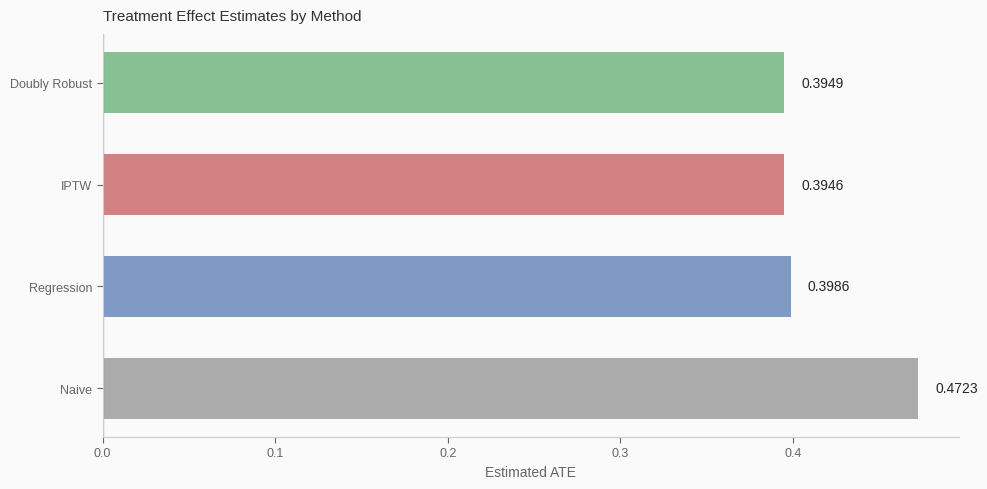

In [6]:
# Visualize the comparison
fig, ax = create_tufte_figure(figsize=(10, 5))

methods = ['Naive', 'Regression', 'IPTW', 'Doubly Robust']
estimates = [naive, ols.params['intervention'], iptw_ate, dr_result['ate']]
colors_list = [COLORS['gray'], COLORS['blue'], COLORS['red'], COLORS['green']]

bars = ax.barh(methods, estimates, color=colors_list, alpha=0.7, height=0.6)

# Add value labels
for bar, est in zip(bars, estimates):
    ax.text(est + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{est:.4f}', va='center', fontsize=10)

ax.axvline(0, color='gray', linewidth=1, alpha=0.5)
set_tufte_title(ax, "Treatment Effect Estimates by Method")
set_tufte_labels(ax, "Estimated ATE", "")

plt.tight_layout()
plt.show()

---

## Implementation

### Production-Ready DR Function

In [7]:
def doubly_robust(df, X_cols, treatment_col, outcome_col, 
                  ps_model=None, outcome_model=None):
    """
    Production doubly robust estimator.
    
    Parameters:
    -----------
    df : DataFrame with all variables
    X_cols : list of covariate column names
    treatment_col : name of treatment column
    outcome_col : name of outcome column
    ps_model : sklearn classifier (default: LogisticRegression)
    outcome_model : sklearn regressor (default: LinearRegression)
    
    Returns:
    --------
    dict with estimates and diagnostics
    """
    X = df[X_cols].values
    T = df[treatment_col].values
    Y = df[outcome_col].values
    n = len(Y)
    
    # Default models
    if ps_model is None:
        ps_model = LogisticRegression(C=1e6, max_iter=1000, solver='lbfgs')
    if outcome_model is None:
        outcome_model = LinearRegression()
    
    # Fit propensity score
    from sklearn.base import clone
    ps_fitted = clone(ps_model).fit(X, T)
    ps = ps_fitted.predict_proba(X)[:, 1]
    
    # Fit outcome models
    mu1_fitted = clone(outcome_model).fit(X[T==1], Y[T==1])
    mu0_fitted = clone(outcome_model).fit(X[T==0], Y[T==0])
    mu1 = mu1_fitted.predict(X)
    mu0 = mu0_fitted.predict(X)
    
    # DR estimate
    dr_i = (mu1 - mu0 + 
            T * (Y - mu1) / ps - 
            (1 - T) * (Y - mu0) / (1 - ps))
    
    ate = dr_i.mean()
    se = dr_i.std() / np.sqrt(n)
    
    # Diagnostics
    ps_range = (ps.min(), ps.max())
    
    return {
        'ate': ate,
        'se': se,
        'ci_lower': ate - 1.96 * se,
        'ci_upper': ate + 1.96 * se,
        'n': n,
        'n_treated': T.sum(),
        'ps_range': ps_range,
        'individual_effects': dr_i
    }

# Test the production function
result = doubly_robust(mindset, covariates, 'intervention', 'achievement_score')

print("PRODUCTION DR ESTIMATOR:")
print(f"ATE: {result['ate']:.4f}")
print(f"SE: {result['se']:.4f}")
print(f"95% CI: [{result['ci_lower']:.4f}, {result['ci_upper']:.4f}]")
print(f"PS range: [{result['ps_range'][0]:.4f}, {result['ps_range'][1]:.4f}]")

PRODUCTION DR ESTIMATOR:
ATE: 0.3949
SE: 0.0180
95% CI: [0.3595, 0.4302]
PS range: [0.1818, 0.4551]


In [8]:
# Bootstrap CI for more robust uncertainty
def bootstrap_dr(df, X_cols, treatment_col, outcome_col, n_bootstrap=500):
    """Bootstrap confidence interval for DR estimator."""
    n = len(df)
    bootstrap_ates = []
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        idx = np.random.choice(n, size=n, replace=True)
        df_boot = df.iloc[idx]
        
        # Compute DR estimate
        result = doubly_robust(df_boot, X_cols, treatment_col, outcome_col)
        bootstrap_ates.append(result['ate'])
    
    bootstrap_ates = np.array(bootstrap_ates)
    
    return {
        'ate': np.mean(bootstrap_ates),
        'se_bootstrap': np.std(bootstrap_ates),
        'ci_lower': np.percentile(bootstrap_ates, 2.5),
        'ci_upper': np.percentile(bootstrap_ates, 97.5)
    }

# Run bootstrap (reduced iterations for notebook)
np.random.seed(42)
boot_result = bootstrap_dr(mindset, covariates, 'intervention', 'achievement_score', n_bootstrap=200)

print("BOOTSTRAP RESULTS:")
print(f"ATE: {boot_result['ate']:.4f}")
print(f"Bootstrap SE: {boot_result['se_bootstrap']:.4f}")
print(f"95% CI (percentile): [{boot_result['ci_lower']:.4f}, {boot_result['ci_upper']:.4f}]")

BOOTSTRAP RESULTS:
ATE: 0.3948
Bootstrap SE: 0.0188
95% CI (percentile): [0.3592, 0.4256]


---

## Production Implementation

This method is implemented in the `causal_inference_mastery` library:

```python
from causal_inference.observational.doubly_robust import (
    doubly_robust_ate,
    doubly_robust_att,
    aipw_estimator,
    DoublyRobustResult
)
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# Basic DR estimator
result = doubly_robust_ate(
    outcome=data['achievement_score'],
    treatment=data['intervention'],
    covariates=data[covariates],
    ps_model=GradientBoostingClassifier(n_estimators=100),
    outcome_model=GradientBoostingRegressor(n_estimators=100)
)
print(f"ATE: {result.ate:.4f}")
print(f"SE: {result.se:.4f}")
print(f"95% CI: [{result.ci_lower:.4f}, {result.ci_upper:.4f}]")

# AIPW (augmented IPW) with cross-fitting
aipw_result = aipw_estimator(
    outcome=data['achievement_score'],
    treatment=data['intervention'],
    covariates=data[covariates],
    cross_fit=True,
    n_folds=5
)
print(f"AIPW estimate: {aipw_result.ate:.4f}")
print(f"Influence function SE: {aipw_result.se:.4f}")
```

**Key differences from notebook demo**:
- Production code implements AIPW with influence function-based standard errors
- Cross-fitting to avoid regularization bias (DML-style)
- Supports flexible ML models for both nuisance functions
- Automatic model diagnostics (R², AUC)
- Cross-validated with Julia implementation

**See also**: `causal_inference_mastery/src/causal_inference/observational/doubly_robust.py`

**External reference**: For production CATE with DR, see [econml.dr](https://github.com/py-why/EconML) which provides DRLearner for heterogeneous effects.

---

## Interview Appendix

### Practice Questions

**Q1: Write the doubly robust estimator formula.**

<details>
<summary>Solution</summary>

**Formula**:

$$\hat{\tau}_{DR} = \frac{1}{n}\sum_{i=1}^{n} \left[ \hat{\mu}_1(X_i) - \hat{\mu}_0(X_i) + \frac{T_i(Y_i - \hat{\mu}_1(X_i))}{\hat{e}(X_i)} - \frac{(1-T_i)(Y_i - \hat{\mu}_0(X_i))}{1-\hat{e}(X_i)} \right]$$

**Components**:
- $\hat{\mu}_1(X), \hat{\mu}_0(X)$: Outcome models for treated and control
- $\hat{e}(X)$: Propensity score
- First term: Outcome model prediction
- Second and third terms: IPTW corrections for residuals

**Intuition**: Start with outcome model, correct its errors using IPTW.

</details>

**Q2: Why do we need both an outcome model and a propensity score model?**

<details>
<summary>Solution</summary>

**The problem**:
- Outcome regression alone: Requires correct functional form
- IPTW alone: Can have high variance with extreme weights

**The solution**:
- DR uses outcome model as "base case"
- IPTW terms correct for any errors in outcome model
- If outcome model is correct, IPTW terms are zero in expectation
- If PS model is correct, IPTW provides consistent correction

**Key insight**: Insurance against misspecification - only ONE model needs to be correct.

</details>

**Q3: What happens if both models are wrong?**

<details>
<summary>Solution</summary>

**Short answer**: The DR estimator can still be biased.

**Details**:
- "Double robustness" ≠ "always robust"
- If BOTH models are wrong, bias can accumulate
- However, bias is typically smaller than single-model approaches
- DR is "locally efficient" - achieves minimum variance when both models correct

**Practical guidance**:
1. Use flexible models (random forest, gradient boosting)
2. Check sensitivity to model choice
3. Cross-fit to avoid overfitting (DML approach)

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 12.

[^2]: Bang, H., & Robins, J. M. (2005). Doubly robust estimation in missing data and causal inference models. *Biometrics*, 61(4), 962-973.

[^3]: Funk, M. J., et al. (2011). Doubly robust estimation of causal effects. *American Journal of Epidemiology*, 173(7), 761-767.

[^4]: Cross-reference: `src/causal_inference/observational/doubly_robust.py` for production implementation.